# Regression model for measuring the water stage and discharge

* Rodrigo Morales Aguayo A01632834
* Jessica Nicole Copado Leal A01637876
* Carlos Estrada Ceballos A01638214
* Andrés Olvera Rodríguez A01638129

## Library Imputation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statistics import mean
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score

from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tools.eval_measures import mse, rmse, meanabs, stde

## Dataset imputation, cleansing and transformation

### Dataset imputation

In [2]:
df = pd.read_csv("Stage_Discharge_Challenge.csv")
print(df.shape)
df.head(10)

(42059, 59)


,SensorTime,CaptureTime,Filename,Agency,SiteNumber,TimeZone,Stage,Discharge,CalcTimestamp,width,...,WeirPt2X,WeirPt2Y,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma
0,09/06/2012 13:15,2012-06-09,StateLineWeir_20120609_Farrell_001.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:28,4288,...,-1,-1,0,0,0.00000,0.00000,0,0,0.00000,0.00000
1,09/06/2012 13:15,2012-06-09,StateLineWeir_20120609_Farrell_002.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:33,4288,...,-1,-1,0,0,0.00000,0.00000,0,0,0.00000,0.00000
2,09/06/2012 13:45,2012-06-09,StateLineWeir_20120609_Farrell_003.jpg,USGS,6674500,MDT,2.96,873.0,2020-03-11T16:58:40,4288,...,-1,-1,0,0,0.00000,0.00000,0,0,0.00000,0.00000
3,09/06/2012 14:45,2012-06-09,StateLineWeir_20120609_Farrell_004.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:47,4288,...,-1,-1,0,0,0.00000,0.00000,0,0,0.00000,0.00000
4,09/06/2012 15:45,2012-06-09,StateLineWeir_20120609_Farrell_005.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:55,4288,...,-1,-1,0,0,0.00000,0.00000,0,0,0.00000,0.00000
5,09/06/2012 16:45,2012-06-09,StateLineWeir_20120609_Farrell_006.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:59:02,4288,...,2455,1900,10487,102251,49449.89403,20971.86345,0,95693,48657.45882,21569.86602
6,09/06/2012 17:45,2012-06-09,StateLineWeir_20120609_Farrell_007.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T17:13:18,4288,...,-1,-1,0,0,0.00000,0.00000,0,0,0.00000,0.00000
7,09/06/2012 18:45,2012-06-09,StateLineWeir_20120609_Farrell_008.jpg,USGS,6674500,MDT,3.01,945.0,2020-03-11T17:24:37,4288,...,-1,-1,0,0,0.00000,0.00000,0,0,0.00000,0.00000
8,09/06/2012 19:45,2012-06-09,StateLineWeir_20120609_Farrell_009.jpg,USGS,6674500,MDT,2.98,902.0,2020-03-11T17:24:39,4288,...,2573,1900,5405,60635,27908.47102,11246.28223,0,56330,27431.23573,11234.57653
9,09/06/2012 20:45,2012-06-09,StateLineWeir_20120609_Farrell_010.jpg,USGS,6674500,MDT,2.96,873.0,2020-03-11T17:24:46,4288,...,-1,-1,0,0,0.00000,0.00000,0,0,0.00000,0.00000


The dataset contains 42,059 rows and 59 columns. 

### Data cleansing

Checking for missing values.

<AxesSubplot:>

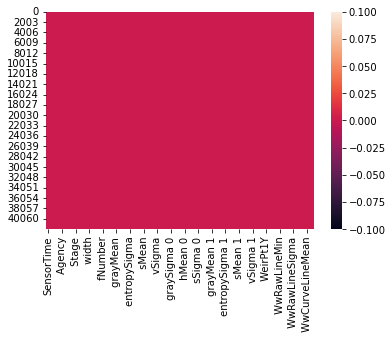

In [3]:
sns.heatmap(df.isnull())

By analyzing the heatmap, there're no missing values in the dataset. The next thing to do is to check the data type on each column/variable.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42059 entries, 0 to 42058
Data columns (total 59 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SensorTime         42059 non-null  object 
 1   CaptureTime        42059 non-null  object 
 2    Filename          42059 non-null  object 
 3    Agency            42059 non-null  object 
 4    SiteNumber        42059 non-null  int64  
 5    TimeZone          42059 non-null  object 
 6    Stage             42059 non-null  float64
 7    Discharge         42059 non-null  float64
 8    CalcTimestamp     42059 non-null  object 
 9    width             42059 non-null  int64  
 10   height            42059 non-null  int64  
 11   exposure          42059 non-null  float64
 12   fNumber           42059 non-null  int64  
 13   isoSpeed          42059 non-null  int64  
 14   shutterSpeed      42059 non-null  float64
 15   grayMean          42059 non-null  float64
 16   graySigma         420

Looking at the dataset info, there are some columns that can be deleted from the set. These columns can be the ones with object type elements or date type elements. Also, with the help of other tools, there are other useless columns that can be deleted.

In [5]:
# Deleting useless columns

df.drop(columns = {"SensorTime", " Filename", " Agency",
                   " SiteNumber", " TimeZone", " CalcTimestamp"}, axis = 1, inplace = True)
df.columns

Index(['CaptureTime', ' Stage', ' Discharge', ' width', ' height', ' exposure',
       ' fNumber', ' isoSpeed', ' shutterSpeed', ' grayMean', ' graySigma',
       ' entropyMean', ' entropySigma', ' hMean', ' hSigma', ' sMean',
       ' sSigma', ' vMean', ' vSigma', ' areaFeatCount', ' grayMean 0',
       ' graySigma 0', ' entropyMean 0', ' entropySigma 0', ' hMean 0',
       ' hSigma 0', ' sMean 0', ' sSigma 0', ' vMean 0', ' vSigma 0',
       ' grayMean 1', ' graySigma 1', ' entropyMean 1', ' entropySigma 1',
       ' hMean 1', ' hSigma 1', ' sMean 1', ' sSigma 1', ' vMean 1',
       ' vSigma 1', ' WeirAngle', ' WeirPt1X', ' WeirPt1Y', ' WeirPt2X',
       ' WeirPt2Y', ' WwRawLineMin', ' WwRawLineMax', ' WwRawLineMean',
       ' WwRawLineSigma', ' WwCurveLineMin', ' WwCurveLineMax',
       ' WwCurveLineMean', ' WwCurveLineSigma'],
      dtype='object')

In [6]:
# Dataset description

df.describe()

,Stage,Discharge,width,height,exposure,fNumber,isoSpeed,shutterSpeed,grayMean,graySigma,...,WeirPt2X,WeirPt2Y,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma
count,42059.000000,42059.000000,42059.000000,42059.000000,42059.000000,42059.000000,42059.000000,42059.000000,42059.000000,42059.000000,...,42059.000000,42059.000000,42059.000000,42059.000000,42059.000000,42059.000000,42059.0,42059.000000,42059.000000,42059.000000
mean,2.878743,970.956439,4288.122114,2848.082170,0.161720,4.001284,200.261537,-0.886029,94.079832,57.578073,...,1898.152025,1632.199410,1977.239592,65649.770061,30264.791368,15731.203913,0.0,60178.912979,29772.190243,15696.114426
std,0.805533,1192.272290,14.458545,9.729114,0.927797,0.087761,31.007433,1.128978,15.028168,9.347902,...,781.483283,661.348746,4652.898679,32223.396961,18033.801170,8019.757667,0.0,30401.134688,17742.927957,8116.052744
min,0.000000,0.000000,4288.000000,2848.000000,0.000125,4.000000,200.000000,-3.000000,55.006235,19.034711,...,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,2.280000,213.000000,4288.000000,2848.000000,0.000400,4.000000,200.000000,-1.000000,85.048836,50.844825,...,2065.000000,1900.000000,0.000000,54055.000000,22276.942955,12542.627860,0.0,48217.500000,21865.041625,12283.186085
50%,2.550000,388.000000,4288.000000,2848.000000,0.000800,4.000000,200.000000,-1.000000,93.352083,57.032581,...,2144.000000,1900.000000,0.000000,71156.000000,30991.115130,16836.506390,0.0,64319.000000,30465.611020,16720.918630
75%,3.290000,1350.000000,4288.000000,2848.000000,0.004000,4.000000,200.000000,-1.000000,102.487423,64.489495,...,2264.000000,1900.000000,1869.000000,87312.000000,39182.093440,20831.296075,0.0,80074.500000,38551.906070,20913.502125
max,6.490000,7920.000000,6000.000000,4000.000000,25.000000,13.000000,4000.000000,12.643856,168.998160,86.339792,...,3275.000000,1900.000000,68747.000000,132262.000000,113048.598100,48565.667750,0.0,130865.000000,110286.915800,48267.082320


In [7]:
# Correlation matrix

corr = df.corr()
corr

,Stage,Discharge,width,height,exposure,fNumber,isoSpeed,shutterSpeed,grayMean,graySigma,...,WeirPt2X,WeirPt2Y,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma
Stage,1.000000,0.970307,-0.001664,-0.001664,-0.070197,-0.000014,-0.001662,-0.075291,-0.187599,0.041895,...,-0.269775,-0.323062,0.029525,-0.115320,-0.004255,-0.056468,NaN,-0.098771,-0.004838,-0.037326
Discharge,0.970307,1.000000,-0.002883,-0.002883,-0.067425,-0.002509,-0.002879,-0.067408,-0.157504,0.032136,...,-0.326738,-0.379252,-0.014486,-0.207538,-0.107299,-0.146490,NaN,-0.193397,-0.107983,-0.131043
width,-0.001664,-0.002883,1.000000,1.000000,-0.001169,0.673548,0.998680,-0.000853,-0.006062,0.014567,...,-0.020525,-0.020857,-0.003589,-0.017207,-0.014174,-0.016567,NaN,-0.016719,-0.014172,-0.016334
height,-0.001664,-0.002883,1.000000,1.000000,-0.001169,0.673548,0.998680,-0.000853,-0.006062,0.014567,...,-0.020525,-0.020857,-0.003589,-0.017207,-0.014174,-0.016567,NaN,-0.016719,-0.014172,-0.016334
exposure,-0.070197,-0.067425,-0.001169,-0.001169,1.000000,0.137941,-0.001167,-0.017767,-0.269368,-0.098630,...,0.030763,0.033712,-0.027959,-0.076175,-0.076941,-0.072712,NaN,-0.070840,-0.076672,-0.073920
fNumber,-0.000014,-0.002509,0.673548,0.673548,0.137941,1.000000,0.672659,-0.001477,-0.006431,0.019818,...,-0.035554,-0.036129,-0.006217,-0.029806,-0.024552,-0.028698,NaN,-0.028960,-0.024549,-0.028294
isoSpeed,-0.001662,-0.002879,0.998680,0.998680,-0.001167,0.672659,1.000000,-0.000852,-0.006069,0.014496,...,-0.020498,-0.020830,-0.003584,-0.017185,-0.014156,-0.016545,NaN,-0.016697,-0.014153,-0.016313
shutterSpeed,-0.075291,-0.067408,-0.000853,-0.000853,-0.017767,-0.001477,-0.000852,1.000000,0.081070,0.022204,...,-0.064322,-0.067978,-0.020677,-0.063323,-0.059572,-0.068802,NaN,-0.063814,-0.059664,-0.069623
grayMean,-0.187599,-0.157504,-0.006062,-0.006062,-0.269368,-0.006431,-0.006069,0.081070,1.000000,-0.350005,...,-0.063344,-0.061302,0.022610,0.137916,0.091134,0.096356,NaN,0.131886,0.089244,0.090716
graySigma,0.041895,0.032136,0.014567,0.014567,-0.098630,0.019818,0.014496,0.022204,-0.350005,1.000000,...,0.010858,0.014153,-0.032403,-0.175010,-0.135579,-0.170656,NaN,-0.180871,-0.136732,-0.171450


There are two dependent variables, which are *Stage* and *Discharge*, in this case, the analysis will be with the *Stage* variable.

<AxesSubplot:>

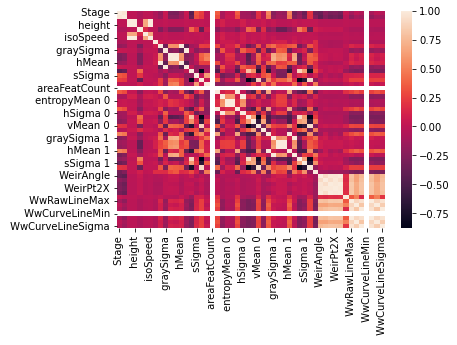

In [8]:
# Correlation heatmap

sns.heatmap(corr)

In [9]:
df.drop(columns = {" areaFeatCount", " WwCurveLineSigma", " fNumber"}, axis = 1, inplace = True)

Due to the fact that the dataset has a lot of variables, it´s gonna take a lot of time to identify what are the variables with high correlation (positve/negative). With the help of the correlation heatmap, the clearest and darkest colors mean a strong correlation. In order to choose the best independent variables, the next step is to create a regression model using the statsmodels library. If the variable predicts our dependent variable *Stage*, it will have a p-value less than 0.05.

### First approach

Separating the independent and dependent variable. Then, will split the dataframe into train and test set.

In [10]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = {"CaptureTime", " Stage", " Discharge"}, axis = 1)
y = df[" Stage"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [89]:
y_train.shape

(29441,)

In [11]:
reg = sm.OLS(y_train, X_train)
model_1 = reg.fit()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Stage   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     1286.
Date:                Mon, 28 Nov 2022   Prob (F-statistic):               0.00
Time:                        14:14:27   Log-Likelihood:                -19302.
No. Observations:               29441   AIC:                         3.870e+04
Df Residuals:                   29395   BIC:                         3.908e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
 width               0.1082      0.259  

In this first model, don´t take in consideration the model´s precision, we are expecting a low score value due to the fact there´s no work donde yet. These step is to help because reduce the amount of independent variables. By checking the second table, the column to check is the one with the p-values, *P>|T|*. The variables that have a p-value greater than 0.05, can be eliminated because they´re not good predictors of the dependent variable.

## Model's influence

For this next part, let's check the influece points in the model. This will help find values with high influence which are not consistent with the rest to build a better model.

In [13]:
influence = model_1.get_influence()
summary = influence.summary_frame()
summary

C:\Users\romor\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:696: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
C:\Users\romor\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:737: RuntimeWarning: invalid value encountered in sqrt
  dffits_ = self.resid_studentized_internal * np.sqrt(hii / (1 - hii))
C:\Users\romor\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:766: RuntimeWarning: invalid value encountered in sqrt
  dffits_ = self.resid_studentized_external * np.sqrt(hii / (1 - hii))


,dfb_ width,dfb_ height,dfb_ exposure,dfb_ isoSpeed,dfb_ shutterSpeed,dfb_ grayMean,dfb_ graySigma,dfb_ entropyMean,dfb_ entropySigma,dfb_ hMean,...,dfb_ WwRawLineSigma,dfb_ WwCurveLineMin,dfb_ WwCurveLineMax,dfb_ WwCurveLineMean,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
12475,-1.354680e-04,1.349849e-04,0.000442,-3.231389e-05,-0.000703,0.003727,-0.001791,0.003742,-0.003105,-0.003779,...,0.001210,4.501461,0.000525,-0.002386,1.725414e-05,0.999185,0.000812,0.028477,0.999185,0.028477
3806,-1.148811e-05,1.131057e-05,0.000048,1.873644e-06,-0.000089,0.000070,-0.000797,0.000224,-0.000273,-0.000031,...,-0.000249,-5.951827,0.000066,0.000299,8.042560e-08,0.065062,0.000892,0.001944,0.065061,0.001944
27050,-4.153551e-06,4.127519e-06,0.000192,1.289339e-07,-0.000009,-0.000283,-0.000096,-0.000033,0.000041,0.000294,...,-0.000260,15.012888,0.000128,-0.000028,2.937785e-08,-0.026183,0.002010,-0.001175,-0.026183,-0.001175
16318,2.193505e-04,-2.176068e-04,-0.001882,-3.968551e-05,-0.000249,0.000769,-0.011058,0.001457,-0.000929,-0.000344,...,-0.002822,10.969872,0.013294,0.003107,4.061343e-05,-1.289781,0.001146,-0.043690,-1.289796,-0.043691
16855,4.253367e-05,-4.229793e-05,-0.000592,2.458127e-05,-0.000194,0.001543,-0.002272,0.000472,-0.000907,-0.001470,...,-0.000655,-4.483372,-0.001162,0.001041,1.265780e-06,-0.373492,0.000426,-0.007713,-0.373487,-0.007713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41993,-6.526368e-06,6.581510e-06,-0.000136,-1.433667e-05,0.000049,-0.000271,0.000123,0.000123,0.000067,0.000244,...,-0.000385,19.432401,0.000075,-0.000333,1.466066e-07,0.068025,0.001487,0.002625,0.068024,0.002625
32103,-3.815057e-06,3.567350e-06,-0.000200,1.062016e-05,0.000080,0.000562,-0.000351,0.000370,-0.000055,-0.000564,...,-0.000056,10.443928,0.000896,0.000019,3.060497e-07,-0.142953,0.000703,-0.003793,-0.142951,-0.003793
30403,3.010037e-08,-1.557037e-08,0.000001,-1.114872e-06,0.000002,0.000026,-0.000019,-0.000032,0.000047,-0.000028,...,0.000016,10.650349,0.000007,0.000034,1.390717e-09,0.012619,0.000410,0.000256,0.012619,0.000256
21243,-4.144779e-05,4.159321e-05,-0.000422,-1.467298e-04,-0.001097,0.004040,-0.003906,0.000152,-0.000556,-0.003696,...,0.001291,0.654838,-0.000777,0.002177,5.797848e-06,0.280957,0.003440,0.016508,0.280952,0.016507


## Outlier detection

Once the influence table is obtained, there are different ways to delete observations with highe influence values. Also, for each outlier process, you have a model, this to check if just one process throws a high $r^{2} score$ and compare it with the rest of them. The processes used are listed below:
* Studentized residuals
* Leveraging
* Cook distance
* All three of them at the same time

### Studentized residuals

The studentized residuals allow comparison of differences between observed and predecited target value in a regression model across different predictor values.

In [213]:
house_residuals = influence.resid_studentized_external

outlier_test = abs(house_residuals) > 2
outlier_points = np.where(outlier_test)

summary.iloc[outlier_points]

,dfb_ width,dfb_ height,dfb_ exposure,dfb_ isoSpeed,dfb_ shutterSpeed,dfb_ grayMean,dfb_ graySigma,dfb_ entropyMean,dfb_ entropySigma,dfb_ hMean,...,dfb_ WwRawLineSigma,dfb_ WwCurveLineMin,dfb_ WwCurveLineMax,dfb_ WwCurveLineMean,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
7449,0.000004,0.000005,0.002463,-0.000209,0.006327,0.023265,0.006863,0.059537,-0.063322,-0.023690,...,-0.004556,13.087597,-0.013061,-0.009746,0.000646,-3.148559,0.003051,-0.174183,-3.149036,-0.174209
24732,0.000286,-0.000285,-0.007113,-0.000120,-0.001574,-0.005299,-0.024319,0.016449,-0.012014,0.006097,...,0.040331,7.615218,-0.013333,0.033214,0.000419,3.152049,0.001979,0.140365,3.152529,0.140387
17647,0.001454,-0.001439,0.020641,0.000188,-0.002639,0.015266,0.021805,0.027251,-0.020033,-0.016116,...,-0.003293,-7.989402,0.004736,-0.007545,0.000409,5.141459,0.000727,0.138690,5.143685,0.138750
5591,0.005851,-0.005775,0.059999,-0.000402,0.000945,0.165295,-0.048685,0.066047,-0.046206,-0.163865,...,-0.021951,8.912351,0.010273,0.028643,0.002363,-3.729625,0.007921,-0.333250,-3.730445,-0.333323
39696,-0.000345,0.000341,0.020633,0.000053,-0.003973,-0.030613,-0.003964,0.004524,-0.006922,0.031918,...,-0.004513,3.721195,0.012879,0.003887,0.000239,-2.177699,0.002361,-0.105938,-2.177838,-0.105944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3560,-0.000194,0.000192,0.000084,-0.000075,-0.000239,-0.004473,-0.004698,0.009457,-0.012069,0.004524,...,0.006168,5.434163,-0.008848,0.010175,0.000108,-2.531469,0.000788,-0.071098,-2.531702,-0.071105
17591,0.000525,-0.000528,0.001127,0.000751,0.001073,-0.001756,0.076859,-0.031506,0.028715,0.000207,...,0.001771,14.011900,-0.003392,-0.016334,0.000631,4.705055,0.001338,0.172224,4.706748,0.172286
3219,0.000449,-0.000453,0.000499,0.000621,0.014897,0.016602,-0.011902,0.011996,-0.006675,-0.016058,...,0.006550,5.666517,-0.005237,-0.008164,0.000656,-2.806466,0.003898,-0.175551,-2.806795,-0.175572
24675,0.000188,-0.000183,-0.008171,-0.000412,-0.000465,0.006125,-0.013871,-0.002125,0.004258,-0.005808,...,0.004494,2.037117,-0.012133,0.019072,0.000146,2.581116,0.001027,0.082756,2.581364,0.082764


### Observations with high leverage

Leverage is a measure of how far an observation on the predictor variable is from the mean of the predictor variable. The higher the leverage value of an observation, the more potential it has to impact the fitted model.

In [214]:
leverage = influence.hat_matrix_diag

p = X_train.shape[1] - 1
cutoff = (2*p + 2)/42059

leverage_test = leverage > cutoff
high_leverage_points = np.where(leverage_test)

summary.iloc[high_leverage_points]

,dfb_ width,dfb_ height,dfb_ exposure,dfb_ isoSpeed,dfb_ shutterSpeed,dfb_ grayMean,dfb_ graySigma,dfb_ entropyMean,dfb_ entropySigma,dfb_ hMean,...,dfb_ WwRawLineSigma,dfb_ WwCurveLineMin,dfb_ WwCurveLineMax,dfb_ WwCurveLineMean,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
7449,0.000004,0.000005,0.002463,-2.093189e-04,0.006327,0.023265,0.006863,0.059537,-0.063322,-0.023690,...,-0.004556,13.087597,-0.013061,-0.009746,6.455265e-04,-3.148559,0.003051,-0.174183,-3.149036,-0.174209
24107,0.000042,-0.000041,0.000148,-9.150008e-07,0.000058,0.000519,0.002051,0.000807,-0.000720,-0.000562,...,-0.000957,5.736795,0.000854,-0.002039,3.261838e-06,0.257902,0.002300,0.012382,0.257898,0.012381
20788,-0.000023,0.000022,-0.003242,3.175277e-06,-0.000124,0.000234,-0.000384,-0.000583,0.000486,-0.000215,...,0.000223,1.884814,0.000322,0.000021,4.883909e-07,-0.098081,0.002380,-0.004791,-0.098080,-0.004791
5591,0.005851,-0.005775,0.059999,-4.021605e-04,0.000945,0.165295,-0.048685,0.066047,-0.046206,-0.163865,...,-0.021951,8.912351,0.010273,0.028643,2.362884e-03,-3.729625,0.007921,-0.333250,-3.730445,-0.333323
39696,-0.000345,0.000341,0.020633,5.250982e-05,-0.003973,-0.030613,-0.003964,0.004524,-0.006922,0.031918,...,-0.004513,3.721195,0.012879,0.003887,2.387820e-04,-2.177699,0.002361,-0.105938,-2.177838,-0.105944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3219,0.000449,-0.000453,0.000499,6.214837e-04,0.014897,0.016602,-0.011902,0.011996,-0.006675,-0.016058,...,0.006550,5.666517,-0.005237,-0.008164,6.557070e-04,-2.806466,0.003898,-0.175551,-2.806795,-0.175572
31921,0.000324,-0.000327,-0.006917,2.326543e-04,-0.004699,0.006359,-0.041256,0.037240,-0.036463,-0.004498,...,-0.002578,10.891051,-0.011091,0.011483,3.825130e-04,-1.956882,0.004673,-0.134082,-1.956976,-0.134089
18430,-0.000219,0.000218,0.002023,-4.773107e-05,0.000726,0.002416,0.005081,-0.001050,0.000887,-0.002582,...,0.041902,18.853135,-0.007902,-0.023710,9.074747e-05,1.258115,0.002687,0.065308,1.258128,0.065309
37619,0.000047,-0.000047,0.000319,-2.432932e-05,-0.000497,0.003168,-0.000399,0.004767,-0.004653,-0.003122,...,-0.000603,12.209904,-0.002918,-0.001832,4.013038e-06,0.223017,0.003778,0.013734,0.223013,0.013733


Text(0, 0.5, 'Leverage')

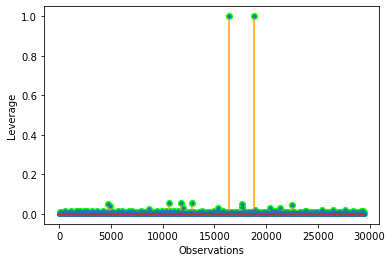

In [215]:
plt.stem(leverage, linefmt = "orange", markerfmt = ".")
plt.scatter(high_leverage_points, leverage[leverage_test], color = "lime")
plt.xlabel("Observations")
plt.ylabel("Leverage")

As seen on the leverage plot, there are two values with a very high leverage, while there are others just surpassing the 0 mark.

### Observations with high cook distance

Cook's distance is an estimate of the influence of a data point. It takes into account both the leverage and residual of each observation. Is a summary of how much a regression model changes when the ith observation is removed.

In [216]:
(cooks, p) = influence.cooks_distance

cutoff_cook = 3*cooks.mean()

cook_distance_test = cooks > cutoff_cook
high_cook_distance_points = np.where(cook_distance_test)

summary.iloc[high_cook_distance_points]

,dfb_ width,dfb_ height,dfb_ exposure,dfb_ isoSpeed,dfb_ shutterSpeed,dfb_ grayMean,dfb_ graySigma,dfb_ entropyMean,dfb_ entropySigma,dfb_ hMean,...,dfb_ WwRawLineSigma,dfb_ WwCurveLineMin,dfb_ WwCurveLineMax,dfb_ WwCurveLineMean,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits


Text(0, 0.5, 'Cook distance')

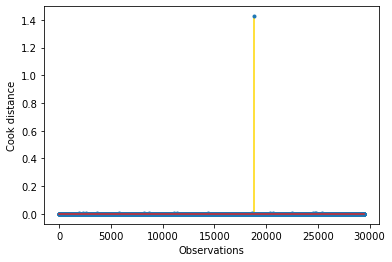

In [217]:
plt.stem(cooks, linefmt = "gold", markerfmt = ".")
plt.scatter(high_cook_distance_points, cooks[high_cook_distance_points], color = "silver")
plt.xlabel("Observations")
plt.ylabel("Cook distance")

Unlike the leverage, here there's just one observation with a very high cook distance.

### Deleting studentized residuals and building model

In [220]:
index_outliers = summary.iloc[outlier_points].index
X_clean = X_train.loc[~X_train.index.isin(index_outliers)]
Y_clean = y_train.loc[~X_train.index.isin(index_outliers)]

In [221]:
out = sm.OLS(Y_clean, X_clean)
model_outliers = out.fit()
print(model_outliers.summary())

                            OLS Regression Results                            
Dep. Variable:                  Stage   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     2283.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:51:38   Log-Likelihood:                -6209.7
No. Observations:               27760   AIC:                         1.251e+04
Df Residuals:                   27714   BIC:                         1.289e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
 width               0.1177      0.168  

### Deleting leverage and building model

In [222]:
index_leverage = summary.iloc[high_leverage_points].index
X_leverage = X_train.loc[~X_train.index.isin(index_leverage)]
Y_leverage = y_train.loc[~X_train.index.isin(index_leverage)]

In [223]:
lev = sm.OLS(Y_leverage, X_leverage)
model_leverage = lev.fit()
print(model_leverage.summary())

                            OLS Regression Results                            
Dep. Variable:                  Stage   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     1389.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:51:43   Log-Likelihood:                -15224.
No. Observations:               25714   AIC:                         3.054e+04
Df Residuals:                   25670   BIC:                         3.089e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
 width           -2.027e-05      0.000  

### Deleting cook distance and building model

In [224]:
index_cook = summary.iloc[high_cook_distance_points].index
X_cook = X_train.loc[~ X_train.index.isin(index_cook)]
Y_cook = y_train.loc[~ X_train.index.isin(index_cook)]

In [225]:
cook = sm.OLS(Y_cook, X_cook)
model_cook = cook.fit()
print(model_cook.summary())

                            OLS Regression Results                            
Dep. Variable:                  Stage   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     1286.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:51:47   Log-Likelihood:                -19302.
No. Observations:               29441   AIC:                         3.870e+04
Df Residuals:                   29395   BIC:                         3.908e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
 width               0.1082      0.259  

### Deleting all processes

In [226]:
total_index = np.concatenate((index_outliers, index_leverage, index_cook), axis = None)

In [227]:
X_total = X_train.loc[~ X_train.index.isin(total_index)]
Y_total = y_train.loc[~ X_train.index.isin(total_index)]

In [228]:
#Splitting the dataset in train and test

xtrain, xtest, ytrain, ytest = train_test_split(X_total, Y_total, test_size = 0.3, random_state = 0) 

In [229]:
total = sm.OLS(ytrain, xtrain)
model_total = total.fit()
print(model_total.summary())

                            OLS Regression Results                            
Dep. Variable:                  Stage   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     1602.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:52:00   Log-Likelihood:                -3121.7
No. Observations:               17085   AIC:                             6331.
Df Residuals:                   17041   BIC:                             6672.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
 width               0.0008   8.54e-05  

In [230]:
res = model_total.resid
ypred = model_total.predict(xtest)
res

2636     0.181113
40593   -0.003389
11177    0.210979
12166   -0.706192
39128   -0.212710
           ...   
14817   -0.059532
4760     0.203154
3065    -0.070945
2265     0.072796
16777   -0.168626
Length: 17085, dtype: float64

In [231]:
print("MSE: ", mse(ytest.squeeze(), y_pred))
print("RSMSE: ", rmse(ytest.squeeze(), y_pred))
print("MAE: ", meanabs(ytest.squeeze(), y_pred))
print("Error estandar: ", stde(ytest.squeeze(), y_pred, ddof = 3))

MSE:  0.08406446736165395
RSMSE:  0.28993873035807743
MAE:  0.21677432693346704
Error estandar:  0.2899795035713248


From all the processes, deleting all of them at the same time, threw the best **$r^{2}score$** with a value of 0.802, better than the others. With that said, will apply more ML regression models in order to obtain the best percentage. Also, looking at the errors, they have low values, so this model is trustable.

<AxesSubplot:ylabel='Count'>

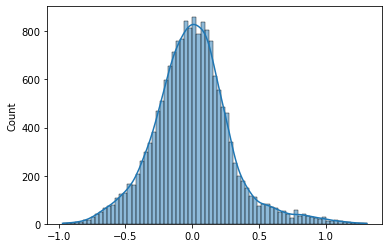

In [232]:
sns.histplot(res, kde=True, bins = 75)

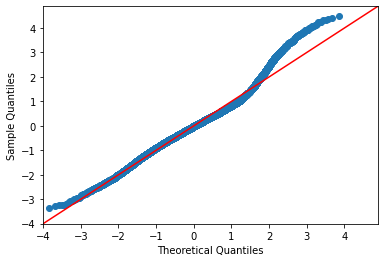

In [234]:
norm_residuals = res/res.std()
figure = sm.qqplot(norm_residuals, line = "45")
plt.show()

By observing the residuals histogram and qqplot, the residuals behave in a linear way and have a normal distribution. 

### Building ML models (Decision Tree Regressor, Random Forest Regressor, Support Vector Regressor and MLP Regressor)

In [235]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [128]:
def TreeRegressor(X_train, y_train, X_test, y_test):
    tree = DecisionTreeRegressor(max_depth = 10, random_state = 0)
    tree.fit(X_train, y_train)
    tree_pred = tree.predict(X_test)
    tree_r2 = r2_score(y_test, tree_pred)
    tree_mean_error = mean_squared_error(y_test, tree_pred)
    tree_root_error = mean_squared_error(y_test, tree_pred, squared = True)
    tree_absolute_error = mean_absolute_error(y_test, tree_pred)
    print("r2 score:",tree_r2)
    print("Mean squared error (MSE):", tree_mean_error)
    print("Root mean squared error (RMSE):", tree_root_error)
    print("Mean absolute error (MAE):", tree_absolute_error)

In [144]:
from sklearn.ensemble import RandomForestRegressor
def RandomRegressor(X_train, y_train, X_test, y_test):
    forest = RandomForestRegressor(max_depth = 15, random_state = 0)
    forest.fit(X_train, y_train)
    forest_pred = forest.predict(X_test)
    forest_r2 = r2_score(y_test, forest_pred)
    forest_mean_error = mean_squared_error(y_test, forest_pred)
    forest_root_error = mean_squared_error(y_test, forest_pred, squared = True)
    forest_absolute_error = mean_absolute_error(y_test, forest_pred)
    print("r2 score:",forest_r2)
    print("Mean squared error (MSE):", forest_mean_error)
    print("Root mean squared error (RMSE):", forest_root_error)
    print("Mean absolute error (MAE):", forest_absolute_error)

In [130]:
from sklearn.svm import SVR
def SupportVectorRegressor(X_train, y_train, X_test, y_test):
    sv = SVR(kernel = "rbf")
    sv.fit(X_train, y_train)
    sv_pred = sv.predict(X_test)
    sv_r2 = r2_score(y_test, sv_pred)
    sv_mean_error = mean_squared_error(y_test, sv_pred)
    sv_root_error = mean_squared_error(y_test, sv_pred, squared = True)
    sv_absolute_error = mean_absolute_error(y_test, sv_pred)
    print("r2 score:",sv_r2)
    print("Mean squared error (MSE):", sv_mean_error)
    print("Root mean squared error (RMSE):", sv_root_error)
    print("Mean absolute error (MAE):", sv_absolute_error)

In [277]:
from sklearn.neural_network import MLPRegressor
def NeuralRegressor(X_train, y_train, X_test, y_test):
    mlp = MLPRegressor(max_iter = 100, random_state = 0)
    mlp.fit(X_train, y_train)
    mlp_pred = mlp.predict(X_test)
    mlp_r2 = r2_score(y_test, mlp_pred)
    mlp_mean_error = mean_squared_error(y_test, mlp_pred)
    mlp_root_error = mean_squared_error(y_test, mlp_pred, squared = True)
    mlp_absolute_error = mean_absolute_error(y_test, mlp_pred)
    print("r2 score:",mlp_r2)
    print("Mean squared error (MSE):", mlp_mean_error)
    print("Root mean squared error (RMSE):", mlp_root_error)
    print("Mean absolute error (MAE):", mlp_absolute_error)

In [281]:
print("Decision Tree Regressor scores")
TreeRegressor(xtrain, ytrain, xtest, ytest)
print("------------------------------")
print("Random Forest Regressor scores")
RandomRegressor(xtrain, ytrain, xtest, ytest)
print("------------------------------")
print("Support Vector Regressor scores")
SupportVectorRegressor(xtrain, ytrain, xtest, ytest)
print("------------------------------")
print("MLP Regressor scores")
NeuralRegressor(xtrain, ytrain, xtest, ytest)

Decision Tree Regressor scores
r2 score: 0.8252936823154983
Mean squared error (MSE): 0.07423337253189911
Root mean squared error (RMSE): 0.07423337253189911
Mean absolute error (MAE): 0.1578338527243486
------------------------------
Random Forest Regressor scores
r2 score: 0.9118831584291581
Mean squared error (MSE): 0.03744117793424774
Root mean squared error (RMSE): 0.03744117793424774
Mean absolute error (MAE): 0.1089957098760697
------------------------------
Support Vector Regressor scores
r2 score: 0.3048800757597723
Mean squared error (MSE): 0.2953590744420336
Root mean squared error (RMSE): 0.2953590744420336
Mean absolute error (MAE): 0.3969163167570166
------------------------------
MLP Regressor scores
r2 score: -1091.1091901902423
Mean squared error (MSE): 464.04130906878333
Root mean squared error (RMSE): 464.04130906878333
Mean absolute error (MAE): 19.270464385486186


The best ML model to predcit the stage level is the Random Forest Regressor that threw a **$r^{2}score$** of 0.91 and low error values like the **mse** with 0.03, terrific! Much better than the other three models.

## Second Approach

For this second approach, will follow the same steps as the first approach, the only thing that changes is that instead of splitting the data usig the train test split function, will separate the dataframe. From year 2012 to 2016 will be the train set and from 2017 to 2019 will be the test set.

In [71]:
df.head()

,CaptureTime,Stage,Discharge,width,height,exposure,isoSpeed,shutterSpeed,grayMean,graySigma,...,WeirPt1Y,WeirPt2X,WeirPt2Y,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean
0,2012-06-09,2.99,916.0,4288,2848,0.000250,200,-1.0,97.405096,39.623303,...,-1,-1,-1,0,0,0.0,0.0,0,0,0.0
1,2012-06-09,2.99,916.0,4288,2848,0.000312,200,-1.0,104.066757,40.179745,...,-1,-1,-1,0,0,0.0,0.0,0,0,0.0
2,2012-06-09,2.96,873.0,4288,2848,0.000312,200,-1.0,105.636831,40.533218,...,-1,-1,-1,0,0,0.0,0.0,0,0,0.0
3,2012-06-09,2.94,846.0,4288,2848,0.000312,200,-1.0,104.418949,41.752678,...,-1,-1,-1,0,0,0.0,0.0,0,0,0.0
4,2012-06-09,2.94,846.0,4288,2848,0.000312,200,-1.0,106.763541,44.442097,...,-1,-1,-1,0,0,0.0,0.0,0,0,0.0


Here's a *GetYear* function in order to separate the original dataframe by year, and generating new dataframes.

In [240]:
def GetYear(data, year):
    return data[data["Year"] == year]

In [241]:
#Creating dataframes by year

df_2012 = GetYear(df, 2012)
df_2013 = GetYear(df, 2013)
df_2014 = GetYear(df, 2014)
df_2015 = GetYear(df, 2015)
df_2016 = GetYear(df, 2016)
df_2017 = GetYear(df, 2017)
df_2018 = GetYear(df, 2018)
df_2019 = GetYear(df, 2019)

In [242]:
#Concatenating the frames

training_set = pd.concat([df_2012, df_2013, df_2014, df_2015, df_2016, df_2017])
test_set = pd.concat([df_2018, df_2019])

In [243]:
print(training_set.shape)
print(test_set.shape)

(28811, 53)
(13248, 53)


In [245]:
#Separating the independet variables from the dependet and building first model

X_training_set = training_set.drop(columns = {"CaptureTime", " Stage"," Discharge", "Month", "Year", "Season"})
y_training_set = training_set[" Stage"]

X_test_set = test_set.drop(columns = {"CaptureTime", " Stage", " Discharge", "Month", "Year", "Season"})
y_test_set = test_set[" Stage"]

In [246]:
reg_2 = sm.OLS(y_training_set, X_training_set)
model_2 = reg_2.fit()
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Stage   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     1368.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        14:05:49   Log-Likelihood:                -20730.
No. Observations:               28811   AIC:                         4.155e+04
Df Residuals:                   28767   BIC:                         4.191e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
 width               0.0010   8.88e-05  

### Model's influence

In [247]:
influence_2 = model_2.get_influence()
summary_2 = influence_2.summary_frame()
summary_2

C:\Users\romor\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:778: RuntimeWarning: invalid value encountered in true_divide
  dfbetas /= np.sqrt(np.diag(self.results.normalized_cov_params))


,dfb_ width,dfb_ height,dfb_ exposure,dfb_ isoSpeed,dfb_ shutterSpeed,dfb_ grayMean,dfb_ graySigma,dfb_ entropyMean,dfb_ entropySigma,dfb_ hMean,...,dfb_ WwRawLineSigma,dfb_ WwCurveLineMin,dfb_ WwCurveLineMax,dfb_ WwCurveLineMean,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.008062,-0.008534,0.006549,-0.008159,-0.001638,0.003929,0.006436,0.008939,-0.012265,-0.003221,...,0.004781,NaN,-0.005124,0.019681,0.000188,-2.697617,0.001214,-0.094061,-2.697912,-0.094071
1,-0.006461,-0.006436,0.004310,-0.006516,-0.001520,0.006703,0.004522,0.011175,-0.014575,-0.006203,...,0.005683,NaN,-0.007034,0.017226,0.000193,-2.696285,0.001244,-0.095162,-2.696579,-0.095172
2,-0.005522,-0.005944,0.003945,-0.005590,-0.000645,0.006515,0.007300,0.008621,-0.011577,-0.006137,...,0.006503,NaN,-0.009444,0.018366,0.000233,-2.856179,0.001343,-0.104739,-2.856534,-0.104752
3,-0.001749,-0.002169,0.003589,-0.001815,-0.000537,0.008468,0.013946,0.008807,-0.010776,-0.008268,...,0.006158,NaN,-0.010750,0.019508,0.000283,-3.009054,0.001469,-0.115425,-3.009475,-0.115441
4,0.001655,0.001365,0.001614,0.001660,-0.001820,0.010368,0.020006,0.017257,-0.018117,-0.010702,...,0.006559,NaN,-0.011592,0.015744,0.000302,-3.009788,0.001564,-0.119123,-3.010210,-0.119140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28806,0.002113,0.002071,0.000059,0.002055,0.000095,0.003034,-0.001236,-0.001546,0.001768,-0.002908,...,0.000210,NaN,-0.000477,0.001018,0.000006,0.198126,0.007348,0.017047,0.198123,0.017046
28807,0.003718,0.003469,-0.000147,0.003666,0.000036,0.004369,-0.002598,-0.002859,0.003299,-0.004127,...,0.000522,NaN,-0.000945,0.001577,0.000017,0.344486,0.006679,0.028249,0.344481,0.028248
28808,0.004406,0.004392,-0.000403,0.004387,0.000208,0.003243,-0.002866,-0.002545,0.003347,-0.003000,...,0.000683,NaN,-0.001550,0.001042,0.000026,0.445146,0.006064,0.034771,0.445140,0.034771
28809,0.010940,0.010983,-0.005138,0.010850,-0.000477,-0.003009,-0.014551,0.003503,-0.000927,0.003752,...,0.003433,NaN,-0.008223,-0.003962,0.000159,1.243340,0.004812,0.086456,1.243352,0.086457


### Studentized residuals

In [248]:
house_residuals = influence_2.resid_studentized_external

outlier_test = abs(house_residuals) > 2
outlier_points = np.where(outlier_test)

summary_2.iloc[outlier_points]

,dfb_ width,dfb_ height,dfb_ exposure,dfb_ isoSpeed,dfb_ shutterSpeed,dfb_ grayMean,dfb_ graySigma,dfb_ entropyMean,dfb_ entropySigma,dfb_ hMean,...,dfb_ WwRawLineSigma,dfb_ WwCurveLineMin,dfb_ WwCurveLineMax,dfb_ WwCurveLineMean,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.008062,-0.008534,0.006549,-0.008159,-0.001638,0.003929,0.006436,0.008939,-0.012265,-0.003221,...,0.004781,NaN,-0.005124,0.019681,0.000188,-2.697617,0.001214,-0.094061,-2.697912,-0.094071
1,-0.006461,-0.006436,0.004310,-0.006516,-0.001520,0.006703,0.004522,0.011175,-0.014575,-0.006203,...,0.005683,NaN,-0.007034,0.017226,0.000193,-2.696285,0.001244,-0.095162,-2.696579,-0.095172
2,-0.005522,-0.005944,0.003945,-0.005590,-0.000645,0.006515,0.007300,0.008621,-0.011577,-0.006137,...,0.006503,NaN,-0.009444,0.018366,0.000233,-2.856179,0.001343,-0.104739,-2.856534,-0.104752
3,-0.001749,-0.002169,0.003589,-0.001815,-0.000537,0.008468,0.013946,0.008807,-0.010776,-0.008268,...,0.006158,NaN,-0.010750,0.019508,0.000283,-3.009054,0.001469,-0.115425,-3.009475,-0.115441
4,0.001655,0.001365,0.001614,0.001660,-0.001820,0.010368,0.020006,0.017257,-0.018117,-0.010702,...,0.006559,NaN,-0.011592,0.015744,0.000302,-3.009788,0.001564,-0.119123,-3.010210,-0.119140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28794,-0.051029,-0.051322,-0.041191,-0.051081,-0.013459,-0.073704,-0.025305,0.016369,-0.016864,0.074005,...,0.011186,NaN,-0.020576,-0.011338,0.001259,2.805739,0.007461,0.243253,2.806074,0.243282
28795,-0.024977,-0.025209,0.140956,-0.025037,-0.011749,-0.040291,-0.010095,0.034429,-0.034335,0.040474,...,0.007630,NaN,-0.029693,-0.007642,0.001826,3.107369,0.008810,0.292955,3.107837,0.292999
28796,-0.037082,-0.037170,0.069179,-0.037128,-0.004744,-0.059915,-0.000430,0.001345,-0.001879,0.061250,...,0.004396,NaN,-0.019697,-0.010564,0.000847,2.333233,0.007261,0.199542,2.333413,0.199557
28797,-0.016744,-0.016723,-0.032376,-0.016806,-0.008688,-0.014809,-0.015757,0.024159,-0.023925,0.015253,...,0.004234,NaN,-0.020756,-0.011832,0.000742,2.418702,0.005922,0.186683,2.418906,0.186699


### Observations with high leverage

In [279]:
leverage = influence_2.hat_matrix_diag

p = X_train.shape[1] - 1
cutoff = (2*p + 2)/42059

leverage_test = leverage > cutoff
high_leverage_points = np.where(leverage_test)

summary_2.iloc[high_leverage_points]

,dfb_ width,dfb_ height,dfb_ exposure,dfb_ isoSpeed,dfb_ shutterSpeed,dfb_ grayMean,dfb_ graySigma,dfb_ entropyMean,dfb_ entropySigma,dfb_ hMean,...,dfb_ WwRawLineSigma,dfb_ WwCurveLineMin,dfb_ WwCurveLineMax,dfb_ WwCurveLineMean,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
11,-0.002596,-0.002607,-0.103435,-0.002654,-0.001748,-0.016006,0.019170,0.010035,-0.005941,0.016133,...,0.003690,NaN,0.015352,0.011784,0.000706,-2.453767,0.005483,-0.182192,-2.453982,-0.182208
14,-0.002510,-0.002600,0.000944,-0.002532,0.000647,-0.000069,0.001604,0.003226,-0.004214,0.000166,...,-0.000105,NaN,0.005569,0.001824,0.000009,-0.418893,0.002330,-0.020245,-0.418887,-0.020245
15,-0.015044,-0.015225,0.004930,-0.015135,0.002250,-0.005641,0.019438,0.018895,-0.024309,0.006194,...,-0.000134,NaN,-0.002684,-0.009913,0.000260,-1.735103,0.004039,-0.110496,-1.735163,-0.110500
24,-0.002780,-0.002901,-0.001406,-0.002816,0.000125,-0.010306,0.014217,-0.004844,-0.007169,0.011120,...,0.006929,NaN,-0.019080,0.019355,0.000708,-3.460846,0.002772,-0.182477,-3.461507,-0.182512
25,0.017704,0.017547,0.002866,0.017694,0.010843,0.000377,-0.019151,0.064865,-0.084856,0.002861,...,-0.000259,NaN,-0.015704,0.002837,0.002982,-4.190904,0.007917,-0.374379,-4.192111,-0.374487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28806,0.002113,0.002071,0.000059,0.002055,0.000095,0.003034,-0.001236,-0.001546,0.001768,-0.002908,...,0.000210,NaN,-0.000477,0.001018,0.000006,0.198126,0.007348,0.017047,0.198123,0.017046
28807,0.003718,0.003469,-0.000147,0.003666,0.000036,0.004369,-0.002598,-0.002859,0.003299,-0.004127,...,0.000522,NaN,-0.000945,0.001577,0.000017,0.344486,0.006679,0.028249,0.344481,0.028248
28808,0.004406,0.004392,-0.000403,0.004387,0.000208,0.003243,-0.002866,-0.002545,0.003347,-0.003000,...,0.000683,NaN,-0.001550,0.001042,0.000026,0.445146,0.006064,0.034771,0.445140,0.034771
28809,0.010940,0.010983,-0.005138,0.010850,-0.000477,-0.003009,-0.014551,0.003503,-0.000927,0.003752,...,0.003433,NaN,-0.008223,-0.003962,0.000159,1.243340,0.004812,0.086456,1.243352,0.086457


Text(0, 0.5, 'Leverage')

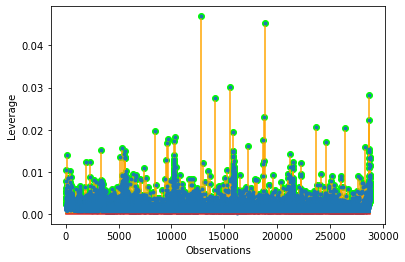

In [280]:
plt.stem(leverage, linefmt = "orange", markerfmt = ".")
plt.scatter(high_leverage_points, leverage[leverage_test], color = "lime")
plt.xlabel("Observations")
plt.ylabel("Leverage")

By observing the plot, there are some observations with high leverage, unlike the first approach.

### Observations with high cook distance

In [282]:
(cooks, p) = influence_2.cooks_distance

cutoff_cook = 3*cooks.mean()

cook_distance_test = cooks > cutoff_cook
high_cook_distance_points = np.where(cook_distance_test)

summary_2.iloc[high_cook_distance_points]

,dfb_ width,dfb_ height,dfb_ exposure,dfb_ isoSpeed,dfb_ shutterSpeed,dfb_ grayMean,dfb_ graySigma,dfb_ entropyMean,dfb_ entropySigma,dfb_ hMean,...,dfb_ WwRawLineSigma,dfb_ WwCurveLineMin,dfb_ WwCurveLineMax,dfb_ WwCurveLineMean,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.008062,-0.008534,0.006549,-0.008159,-0.001638,0.003929,0.006436,0.008939,-0.012265,-0.003221,...,0.004781,NaN,-0.005124,0.019681,0.000188,-2.697617,0.001214,-0.094061,-2.697912,-0.094071
1,-0.006461,-0.006436,0.004310,-0.006516,-0.001520,0.006703,0.004522,0.011175,-0.014575,-0.006203,...,0.005683,NaN,-0.007034,0.017226,0.000193,-2.696285,0.001244,-0.095162,-2.696579,-0.095172
2,-0.005522,-0.005944,0.003945,-0.005590,-0.000645,0.006515,0.007300,0.008621,-0.011577,-0.006137,...,0.006503,NaN,-0.009444,0.018366,0.000233,-2.856179,0.001343,-0.104739,-2.856534,-0.104752
3,-0.001749,-0.002169,0.003589,-0.001815,-0.000537,0.008468,0.013946,0.008807,-0.010776,-0.008268,...,0.006158,NaN,-0.010750,0.019508,0.000283,-3.009054,0.001469,-0.115425,-3.009475,-0.115441
4,0.001655,0.001365,0.001614,0.001660,-0.001820,0.010368,0.020006,0.017257,-0.018117,-0.010702,...,0.006559,NaN,-0.011592,0.015744,0.000302,-3.009788,0.001564,-0.119123,-3.010210,-0.119140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28797,-0.016744,-0.016723,-0.032376,-0.016806,-0.008688,-0.014809,-0.015757,0.024159,-0.023925,0.015253,...,0.004234,NaN,-0.020756,-0.011832,0.000742,2.418702,0.005922,0.186683,2.418906,0.186699
28798,-0.010870,-0.010875,-0.011940,-0.010940,0.001132,-0.006116,0.001146,0.002332,0.000175,0.006278,...,0.019114,NaN,-0.002045,-0.031437,0.000218,1.237083,0.006646,0.101186,1.237094,0.101187
28799,0.002541,0.002263,-0.010950,0.002474,0.000380,-0.014374,-0.007794,0.008068,-0.005421,0.014727,...,0.025150,NaN,-0.003330,-0.040596,0.000248,1.313577,0.006716,0.108015,1.313593,0.108016
28809,0.010940,0.010983,-0.005138,0.010850,-0.000477,-0.003009,-0.014551,0.003503,-0.000927,0.003752,...,0.003433,NaN,-0.008223,-0.003962,0.000159,1.243340,0.004812,0.086456,1.243352,0.086457


Text(0, 0.5, 'Cook distance')

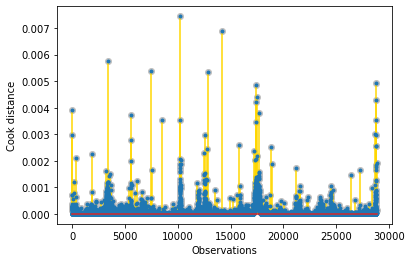

In [283]:
plt.stem(cooks, linefmt = "gold", markerfmt = ".")
plt.scatter(high_cook_distance_points, cooks[high_cook_distance_points], color = "silver")
plt.xlabel("Observations")
plt.ylabel("Cook distance")

As in the leverage plot, there are a lot of observations with a high cook distance.

### Deleting studentized residuals and building model

In [260]:
index_outliers = summary_2.iloc[outlier_points].index
X_train_clean = X_training_set.loc[~X_training_set.index.isin(index_outliers)]
y_train_clean = y_training_set.loc[~X_training_set.index.isin(index_outliers)]

In [261]:
outliers = sm.OLS(y_train_clean, X_train_clean)
model_outliers = outliers.fit()
print(model_outliers.summary())

                            OLS Regression Results                            
Dep. Variable:                  Stage   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     2514.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:02:31   Log-Likelihood:                -7156.7
No. Observations:               26975   AIC:                         1.440e+04
Df Residuals:                   26931   BIC:                         1.476e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
 width               0.0015   5.87e-05  

In [284]:
res_outliers = model_outliers.resid
ypred_outliers = model_outliers.predict(X_test_set)
res_outliers

5       -0.298776
8        0.320335
9       -0.627401
13      -0.050516
14      -0.110345
           ...   
28805    0.480574
28806    0.213322
28807    0.273916
28808    0.301864
28809    0.648030
Length: 26975, dtype: float64

In [285]:
print("MSE: ", mse(y_test_set.squeeze(), ypred_outliers))
print("RSMSE: ", rmse(y_test_set.squeeze(), ypred_outliers))
print("MAE: ", meanabs(y_test_set.squeeze(), ypred_outliers))
print("Error estandar: ", stde(y_test_set.squeeze(), ypred_outliers, ddof = 3))

MSE:  0.2056972836040019
RSMSE:  0.4535386241589595
MAE:  0.3409913567789698
Error estandar:  0.3759105848908428


<AxesSubplot:ylabel='Count'>

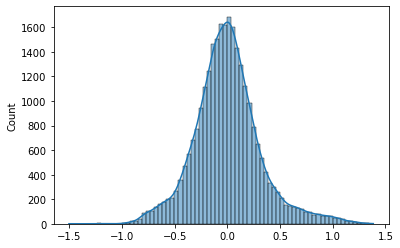

In [286]:
sns.histplot(res_outliers, kde=True, bins = 75)

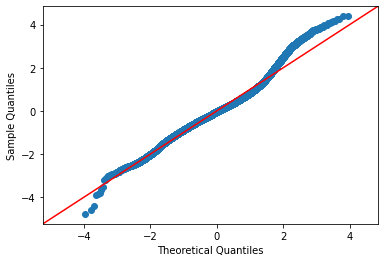

In [287]:
norm_res_outliers = res_outliers/res_outliers.std()
figure = sm.qqplot(norm_res_outliers, line = "45")
plt.show()

By observing the residuals histogram and qqplot, the residuals behave in a linear way and have a normal distribution. 

### Deleting leverage and building model

In [262]:
index_leverage = summary_2.iloc[high_leverage_points].index
X_train_leverage = X_training_set.loc[~X_training_set.index.isin(index_leverage)]
y_train_leverage = y_training_set.loc[~X_training_set.index.isin(index_leverage)]

In [263]:
leverages = sm.OLS(y_train_leverage, X_train_leverage)
model_leverage = leverages.fit()
print(model_leverages.summary())

                            OLS Regression Results                            
Dep. Variable:                  Stage   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     1656.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:02:45   Log-Likelihood:                -16668.
No. Observations:               25583   AIC:                         3.341e+04
Df Residuals:                   25544   BIC:                         3.373e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
 width               0.0012      0.000  

### Deleting cook distance and building model

In [264]:
index_cook = summary_2.iloc[high_cook_distance_points].index
X_train_cook = X_training_set.loc[~ X_training_set.index.isin(index_cook)]
y_train_cook = y_training_set.loc[~ X_training_set.index.isin(index_cook)]

In [265]:
cooked = sm.OLS(y_train_cook, X_train_cook)
model_cook = cooked.fit()
print(model_cook.summary())

                            OLS Regression Results                            
Dep. Variable:                  Stage   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     2434.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:02:54   Log-Likelihood:                -7526.9
No. Observations:               26715   AIC:                         1.514e+04
Df Residuals:                   26671   BIC:                         1.550e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
 width               0.0016   6.45e-05  

### Deleting all three processes

In [266]:
total_index_2 = np.concatenate((index_outliers, index_leverage, index_cook), axis = None)

In [267]:
X_train_total = X_training_set.loc[~ X_training_set.index.isin(total_index)]
y_train_total = y_training_set.loc[~ X_training_set.index.isin(total_index)]

In [268]:
tot = sm.OLS(y_train_total, X_train_total)
total_model = tot.fit()
print(total_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Stage   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     1653.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:03:08   Log-Likelihood:                -11201.
No. Observations:               24826   AIC:                         2.249e+04
Df Residuals:                   24782   BIC:                         2.285e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
 width               0.0014   8.56e-05  

The processes that threw the best **$r^{2}score$** was the studentized residuals with 0.801. 

### Building ML models

In [278]:
print("Decision Tree Regressor scores")
TreeRegressor(X_train_clean, y_train_clean, X_test_set, y_test_set)
print("------------------------------")
print("Random Forest Regressor scores")
RandomRegressor(X_train_clean, y_train_clean, X_test_set, y_test_set)
print("------------------------------")
print("Support Vector Regressor scores")
SupportVectorRegressor(X_train_clean, y_train_clean, X_test_set, y_test_set)
print("------------------------------")
print("MLP Regressor scores")
NeuralRegressor(X_train_clean, y_train_clean, X_test_set, y_test_set)

Decision Tree Regressor scores
r2 score: 0.3438572335928919
Mean squared error (MSE): 0.25310834649694347
Root mean squared error (RMSE): 0.25310834649694347
Mean absolute error (MAE): 0.34076107139304734
------------------------------
Random Forest Regressor scores
r2 score: 0.5519599760739231
Mean squared error (MSE): 0.1728323094093502
Root mean squared error (RMSE): 0.1728323094093502
Mean absolute error (MAE): 0.29036569295015197
------------------------------
Support Vector Regressor scores
r2 score: 0.05946129616394302
Mean squared error (MSE): 0.36281463171174855
Root mean squared error (RMSE): 0.36281463171174855
Mean absolute error (MAE): 0.45964094953648577
------------------------------
MLP Regressor scores
r2 score: -1637.8183113941418
Mean squared error (MSE): 632.177346520528
Root mean squared error (RMSE): 632.177346520528
Mean absolute error (MAE): 16.035323478837054


The ML model with the highest **$r^{2}score$** was the OLS with 0.802. With that said, the first approach threw a better results. There's still a lot work to be done, because you cannot predict the stage level using data from a camera. For example, if you stand next to a river, it'a difficult to say the stage it has. Maybe for future works, you can put a camera inside the river or put a stick with measures and get the camera to do the same work it did for this task but in this time, the camera will be underwater taking pictures of the stick to see at what level is the stage.